In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve
from uteis import plotar_grafico_cotovelo, procurar_num_componentes, obter_distancias_inter, obter_distancias_intra

from numpy.linalg import norm
from PIL import Image

# Importar Dataset

In [3]:
# Importando o dataset
faces_bunch = fetch_olivetti_faces()

data = faces_bunch.data
images = faces_bunch.images 
targets = faces_bunch.target

# Primeiro Teste: Analisando Comportamento do PCA para um Dataset com duas pessoas

Aqui foram selecionadas 2 pessoas aleatórias do dataset `fetch_olivetti_faces`. Dessas 2 pessoas, foi requisitado as 10 fotos de cada uma delas e selecionada, também aleatóriamente 1 foto de cada pessoa, a qual servirá de teste futuramente. No bloco imediatamente abaixo é possível perceber a obtenção das imagens da primeira e da segunda pessoa e a separação das respectivas imagens de teste.


In [ ]:
ids = np.unique(targets)  # IDs únicos das pessoas

np.random.seed(43)  # Para reprodutibilidade

# Seleciona dois IDs aleatórios
id1 = np.random.choice(ids)
id2 = np.random.choice(ids[ids != id1])

# Para cada pessoa, seleciona os índices das imagens
indices_pessoa1 = np.where(targets == id1)[0]
indices_pessoa2 = np.where(targets == id2)[0]

# Seleciona aleatoriamente um índice de teste para cada pessoa
indice_teste_pessoa1 = np.random.choice(indices_pessoa1, size=1, replace=False)[0]
indice_teste_pessoa2 = np.random.choice(indices_pessoa2, size=1, replace=False)[0]

# Índices de treino (remove o de teste)
indices_treino_pessoa1 = indices_pessoa1[indices_pessoa1 != indice_teste_pessoa1]
indices_treino_pessoa2 = indices_pessoa2[indices_pessoa2 != indice_teste_pessoa2]

# Obtém as imagens de treino e teste para cada pessoa
pessoa1_treino = data[indices_treino_pessoa1]
pessoa2_treino = data[indices_treino_pessoa2]
pessoa1_teste = data[indice_teste_pessoa1]
pessoa2_teste = data[indice_teste_pessoa2]

# Concatena os dados de treino das duas pessoas
data_2_pessoas = np.concatenate((pessoa1_treino, pessoa2_treino), axis=0)
# Concatena os targets de treino das duas pessoas
targets_2_pessoas = np.concatenate((
    np.full(len(pessoa1_treino), id1),
    np.full(len(pessoa2_treino), id2)
))

# Imagens de teste e seus targets
data_teste_2_pessoas = np.stack([pessoa1_teste, pessoa2_teste])
targets_teste_2_pessoas = np.array([id1, id2])

(18, 4096)

Tendo as imagens das duas pessoas selecionadas em uma matriz `18x4096`, lembrando que cada imagem se encontra em uma linha, iremos agora aplicar o PCA para reduzir nossos dados para dimensão 2 e assim analisar o quanto essa redução de dimensionalidade é capaz de capturar nossos dados originais.

In [23]:
# Como selecionamos apenas duas pessoas, o número de componentes 
# principais que queremos são 2. Para simplificar os nomes das variáveis
# indicarei 2_ para indicar que são dados de duas pessoas.

num_componentes = 2
pca = PCA(n_components=num_componentes)
# Ajusta o PCA aos dados de treino
pca.fit(data_2_pessoas)

eigenfaces_2_ = pca.components_
eigenfaces_importancia_2_ = pca.explained_variance_
eigenfaces_importancia_relativa_2_ = pca.explained_variance_ratio_

projecoes_2_ = pca.transform(data_2_pessoas)
projecoes_teste_2_ = pca.transform(data_teste_2_pessoas)


Após o PCA ser aplicado, agora desejamos observar a disposição das nossas imagens (agora em 2D) plotadas em um gráfico

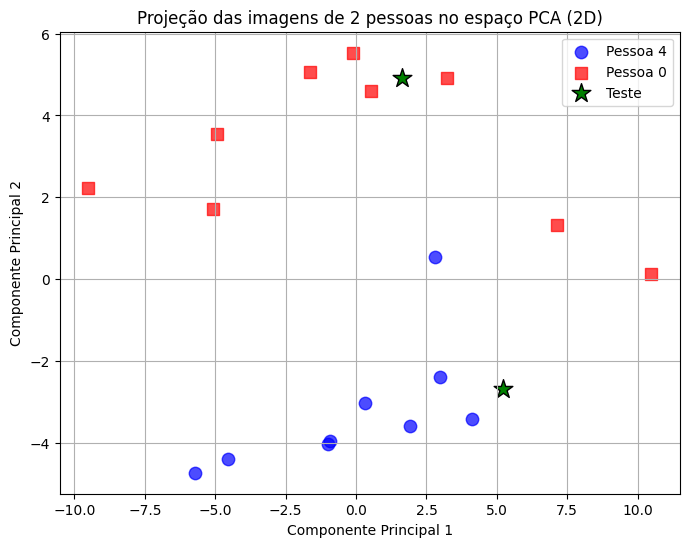

In [24]:
# Plota as projeções das imagens das duas pessoas no espaço 2D das componentes principais
plt.figure(figsize=(8, 6))
for id_pessoa, cor, marcador in zip([id1, id2], ['blue', 'red'], ['o', 's']):
    idx = targets_2_pessoas == id_pessoa
    plt.scatter(projecoes_2_[idx, 0], projecoes_2_[idx, 1], 
                label=f'Pessoa {id_pessoa}', c=cor, marker=marcador, s=80, alpha=0.7)

# Plota as imagens de teste
plt.scatter(projecoes_teste_2_[:, 0], projecoes_teste_2_[:, 1], 
            label='Teste', c='green', marker='*', s=200, edgecolor='black')

plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Projeção das imagens de 2 pessoas no espaço PCA (2D)')
plt.legend()
plt.grid(True)
plt.show()

Para efeito de análise dessa primeira parte, é interessante avaliar o quanto que foi capturado nessa aproximação utilzando apenas o PCA2

In [25]:
percentual_capturado = np.sum(eigenfaces_importancia_relativa_2_)
print(f"Percentual de variância capturado pelas 2 primeiras componentes principais: {percentual_capturado:.2%}")

Percentual de variância capturado pelas 2 primeiras componentes principais: 59.78%


Note pela saída acima que foi possível capturar 59.78% dos dados originais apenas com o PCA2

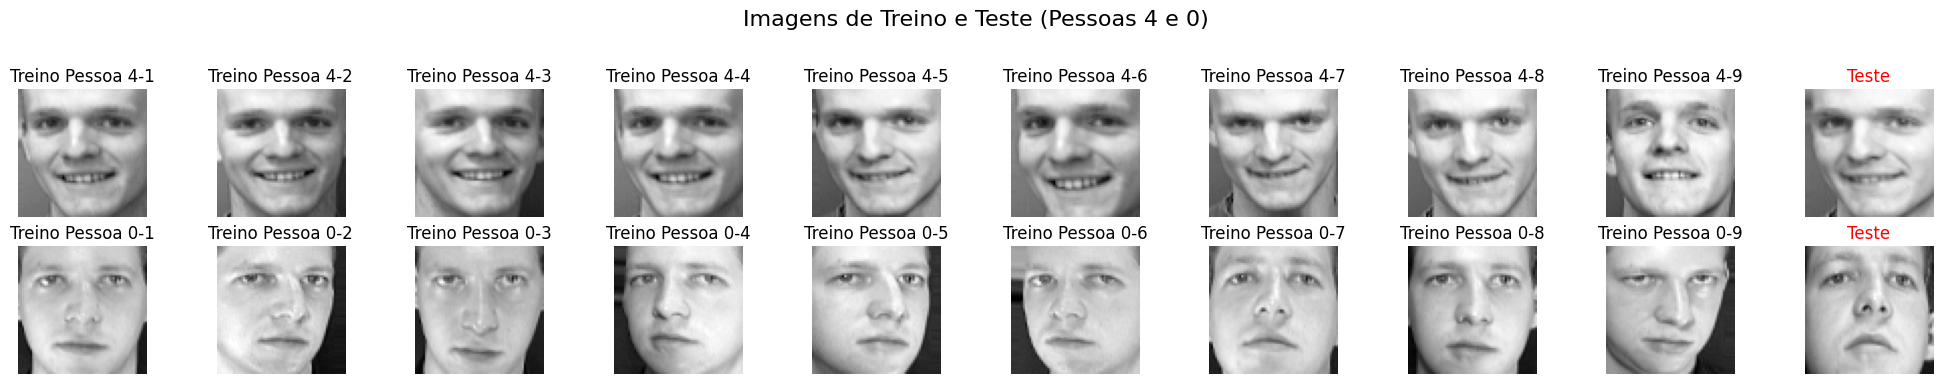

In [20]:
# Cria um grid 2x10 para exibir as imagens
fig, axes = plt.subplots(2, 10, figsize=(20, 4))
fig.suptitle(f'Imagens de Treino e Teste (Pessoas {id1} e {id2})', fontsize=16)

# Exibe as 9 imagens de treino da pessoa 1
for i in range(9):
    ax = axes[0, i]
    ax.imshow(pessoa1_treino[i].reshape(64, 64), cmap='gray')
    ax.set_title(f'Treino Pessoa {id1}-{i+1}')
    ax.axis('off')

# Exibe a imagem de teste da pessoa 1 na 10ª coluna
axes[0, 9].imshow(pessoa1_teste.reshape(64, 64), cmap='gray')
axes[0, 9].set_title('Teste')
axes[0, 9].axis('off')
axes[0, 9].title.set_color('red')


# Exibe as 9 imagens de treino da pessoa 2
for i in range(9):
    ax = axes[1, i]
    ax.imshow(pessoa2_treino[i].reshape(64, 64), cmap='gray')
    ax.set_title(f'Treino Pessoa {id2}-{i+1}')
    ax.axis('off')

# Exibe a imagem de teste da pessoa 2 na 10ª coluna
axes[1, 9].imshow(pessoa2_teste.reshape(64, 64), cmap='gray')
axes[1, 9].set_title('Teste')
axes[1, 9].axis('off')
axes[1, 9].title.set_color('red')

plt.tight_layout(rect=(0, 0.03, 1, 0.95))
plt.show()

---

# Segundo Teste: Aplicando PCA em todo o Dataset

Para esse segundo teste, o objetivo é utilizar as imagens de todas as pessoas do Dataset. De início, desejo selecionar 1 imagem de cada pessoa para usar de teste após a aplicação do PCA. Isso é feito no bloco abaixo.

In [28]:
# Desejo selecionar um número de imagens que não serão aplicadas no
# treino do algoritmo para utilizar de teste posteriormente
def separar_treino_teste(targets):
    indices_teste = []
    ids = np.unique(targets)
    # Para cada pessoa, seleciona aleatoriamente 1 imagem para teste
    for id_pessoa in ids:
        # Encontra os índices de todas as imagens dessa pessoa
        indices = np.where(targets == id_pessoa)[0]
        # Escolhe aleatoriamente 1 índice para teste
        indice_teste = np.random.choice(indices, size=1, replace=False)
        indices_teste.append(indice_teste)

    # Converte para array unidimensional
    indices_teste = np.concatenate(indices_teste)

    # Máscara booleana para separar treino e teste
    mascara_teste = np.zeros(len(targets), dtype=bool)
    mascara_teste[indices_teste] = True  # True = teste, False = treino

    return mascara_teste

mascara_teste = separar_treino_teste(targets)

# Divide-se os dados
data_treino, data_teste = data[~mascara_teste], data[mascara_teste]
targets_treino, targets_teste = targets[~mascara_teste], targets[mascara_teste]

## Obter número de componentes ideal

 Após separadas as imagens para o treino e para o teste, minha ideia é avaliar qual número ideal de componentes são necessárias para a gente capturar 95% dos dados originais

In [ ]:
# Esse bloco objetiva a decisão do número de componentes que serão
# escolhidos
pca = PCA(n_components=None)
pca.fit(data_treino)
all_autovalores = pca.explained_variance_
all_autovalores_percentuais = pca.explained_variance_ratio_

Para ter um olhar visual sobre as informações alguns plots de gráficos serão mostrados abaixo. Nesses gráficos temos o valor dos autovalores por número de componentes

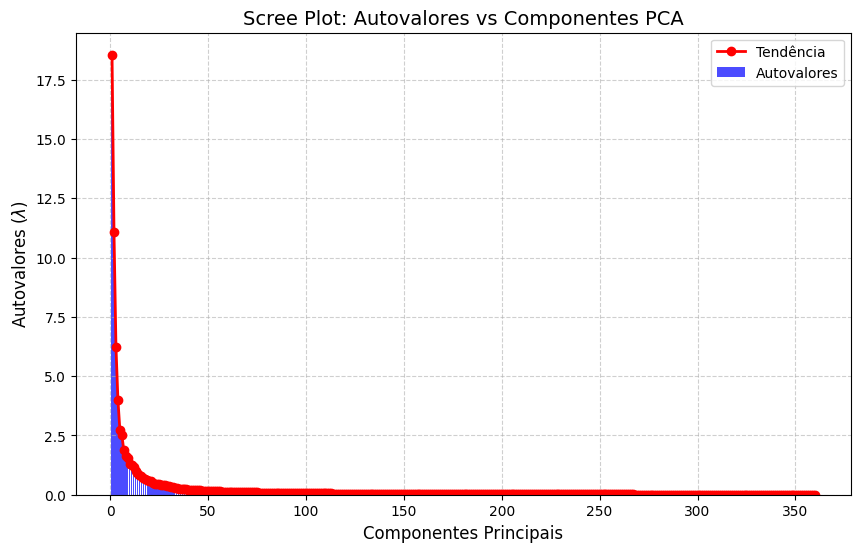

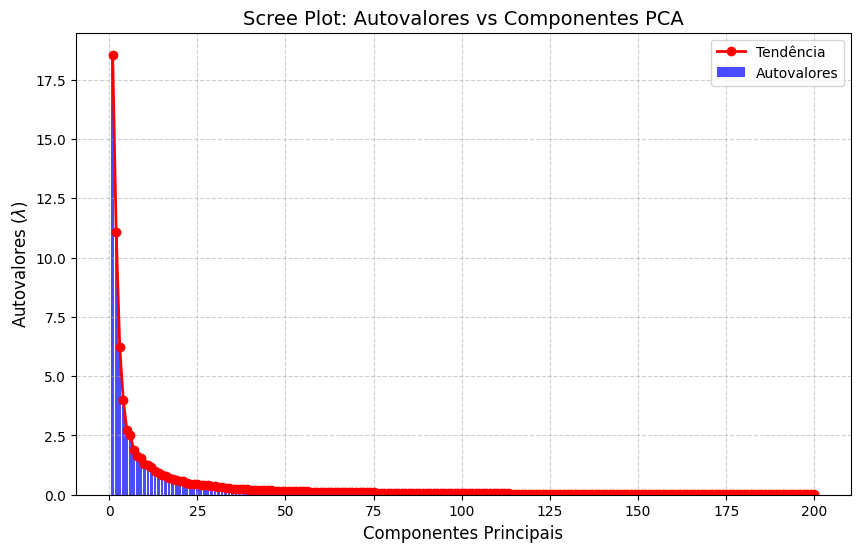

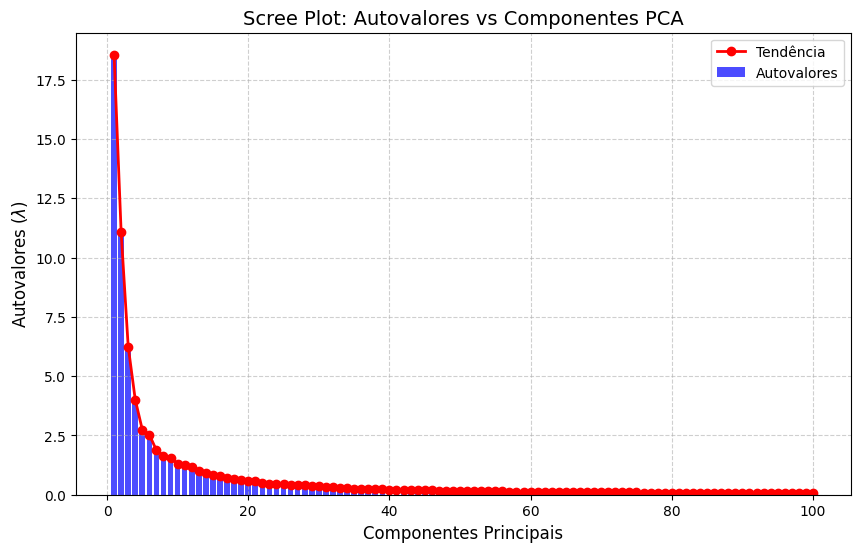

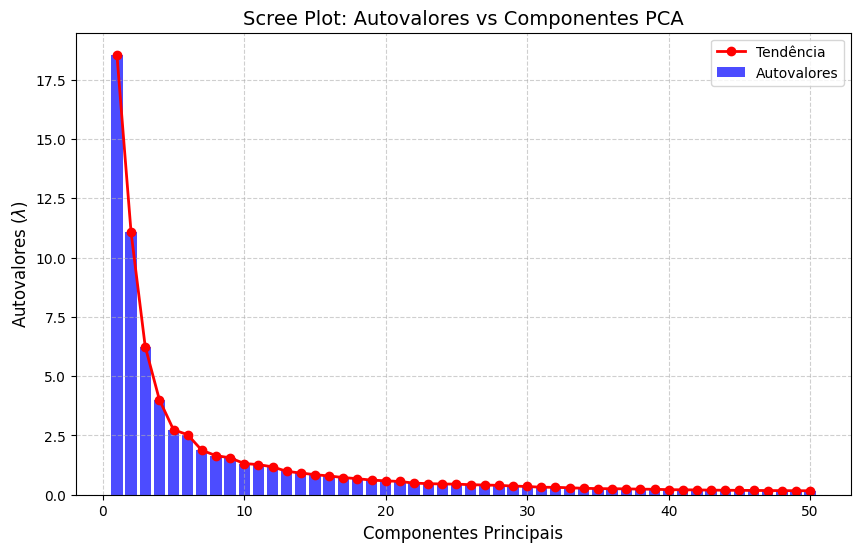

In [31]:
# Avalia-se diferentes gráficos cotovelos para obter o número
# de componentes ideal visualmente
plotar_grafico_cotovelo(all_autovalores)
plotar_grafico_cotovelo(all_autovalores[:200])
plotar_grafico_cotovelo(all_autovalores[:100])
plotar_grafico_cotovelo(all_autovalores[:50])

Mesmo com o zoom aplicado a cada gráfico, não é possível obter a informação precisa do percentual do dado capturado. Por isso a melhor forma de fazer isso é analisar matematicamente somando os autovalores até uma determinada componentes e dividindo pela soma total de todas as componentes. Ou melhor, como temos um vetor que nos diz o percentual que cada autovalor captura o dado, basta somarmos esses valores até atingirmos a métrica de 0.95 que é desejada.

In [8]:
# Matemáticamente agora desejamos obter o número de componentes
# para um determinado percentual de precisão desejado.
percentual_desejado = 0.95
k = procurar_num_componentes(percentual_desejado, all_autovalores_percentuais)
print(f"{k} componentes necessárias para {percentual_desejado * 100} % de precisão")

117 componentes necessárias para 95.0 % de precisão


Assim foi possível obter que `117` componentes são suficientes para haver uma captura de `95%` do Dataset

## Obter as eigenfaces, seus pesos e os autovalores associados

A partir do número de componentes ideal obtido anteriormente, agora aplicaremos o PCA117 em cima do nosso dataset, para obtermos as projeções e aplicar os testes.

In [9]:
# Aplicação do PCA para o número de componentes obtido no bloco acima
pca = PCA(n_components=k)
pca.fit(data_treino)

eigenfaces = pca.components_    # autovetores da matriz AA^t
eigenfaces_importancia = pca.explained_variance_    # autovalores da matriz AA^t
eigenfaces_importancia_percentual = pca.explained_variance_ratio_   # autovalores percentuais da matriz AA^t
                                                                    # autovalor/sum(autovalores)

projecoes = pca.fit_transform(data_treino) # matriz com os pesos de cada eigenface
                                    # para cada foto do dataset original

data_aprox = pca.inverse_transform(projecoes)  # aproximação da matriz data a partir das projeçoes feitas

# Definindo o limiar de similaridade

In [10]:
# Definindo o limiar de similaridade
ids = np.unique(targets)
distancias_intra = obter_distancias_intra(ids, projecoes, targets_treino)
distancias_inter = obter_distancias_inter(ids, projecoes, targets_treino)

media_intra = np.mean(distancias_intra)
dp_intra = np.std(distancias_intra)

media_inter = np.mean(distancias_inter)
dp_inter = np.std(distancias_inter)

limiar1 = media_intra + 2 * dp_intra    # limiar de similaridade baseado em desvio padrão

In [11]:
def obter_limiar_eer(distancias_intra, distancias_inter):
    # Cria-se vetores de labels (0 = intra-classe, 1 = inter-classe)
    labels = np.concatenate([
        np.zeros(len(distancias_intra)),  # 0 para intra-classe
        np.ones(len(distancias_inter))    # 1 para inter-classe
    ])

    # Concatenar todas as distâncias
    distancias = np.concatenate([distancias_intra, distancias_inter])

    # Calcular FPR e TPR (usando a função ROC do scikit-learn)
    fpr, tpr, limiares = roc_curve(labels, distancias)

    # Encontrar o limiar onde FPR ≈ 1 - TPR (FNR)
    limiar_eer = limiares[np.argmin(np.abs(fpr - (1 - tpr)))]
    
    return limiar_eer

limiar_eer = obter_limiar_eer(distancias_intra, distancias_inter)
print(f"Limiar EER: {limiar_eer}")

Limiar EER: 10.191056251525879


# Utilizando as imagens de teste

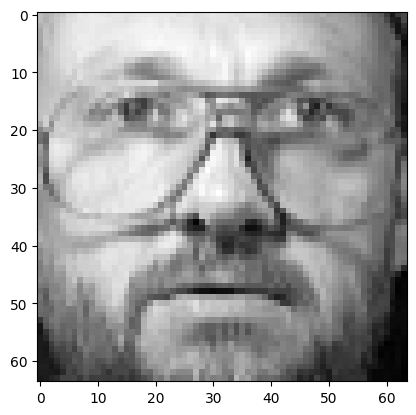

In [12]:
face1 = images[0]
plt.imshow(face1, cmap="gray")
plt.show()

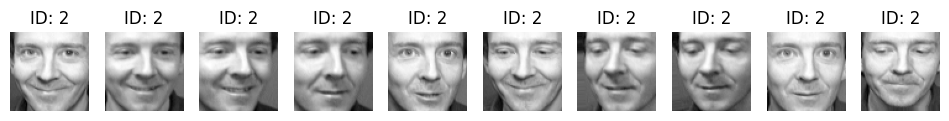

In [13]:
# Filtra apenas imagens da pessoa com ID=7
id_person = 2
person_images = images[targets == id_person]

# Exibe 5 imagens dessa pessoa
fig, axes = plt.subplots(1, 10, figsize=(12, 3))
for i, ax in enumerate(axes.flat):
    ax.imshow(person_images[i], cmap='gray')
    ax.set_title(f"ID: {id_person}")
    ax.axis('off')

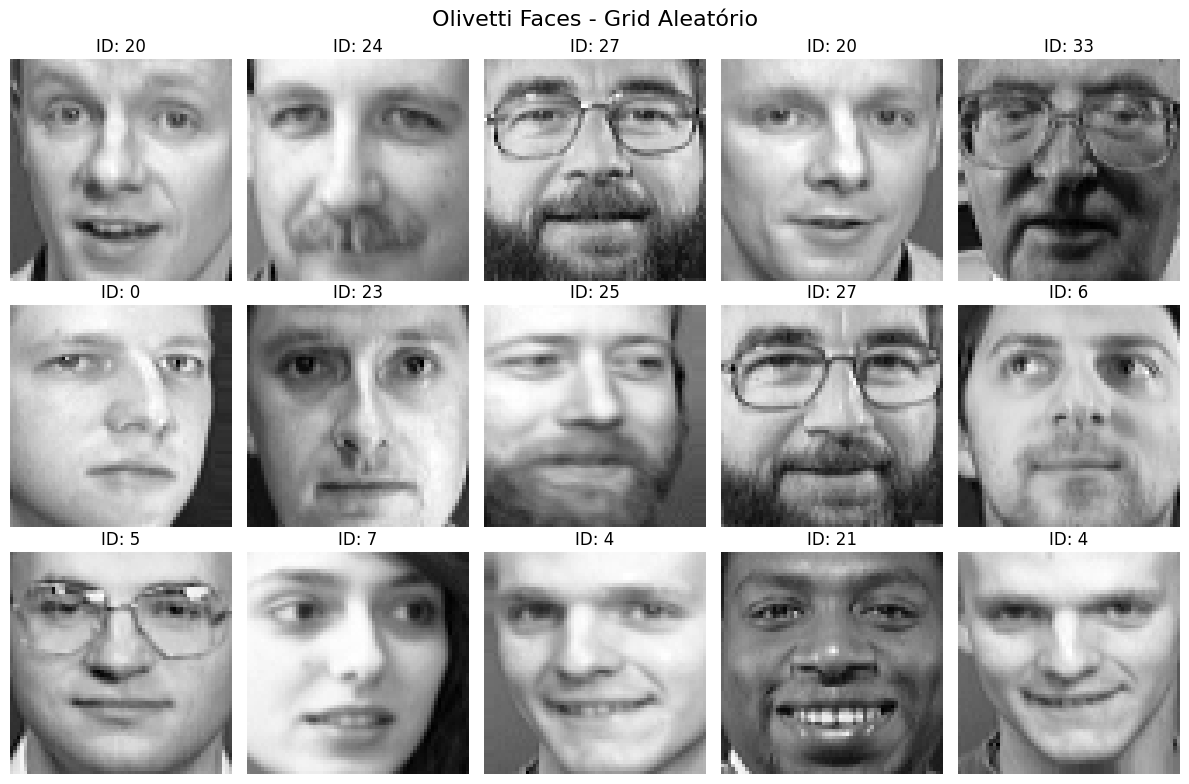

In [14]:
# Configurações do grid
n_rows = 3
n_cols = 5
total_imgs = n_rows * n_cols

# Cria a figura e os subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 8))
fig.suptitle("Olivetti Faces - Grid Aleatório", fontsize=16)

# Embaralha os índices para pegar imagens aleatórias
random_indices = np.random.choice(len(images), total_imgs, replace=False)

# Preenche o grid
for i, ax in enumerate(axes.flat):
    ax.imshow(images[random_indices[i]], cmap='gray')
    ax.set_title(f"ID: {targets[random_indices[i]]}")
    ax.axis('off')

plt.tight_layout()
plt.show()